<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_pandas_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Parquet Derivatives

In this notebook, we'll setup an enviroment, then download a dataset of web archive collection derivatives that were produced with the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). These derivatives are in the [Apache Parquet](https://parquet.apache.org/) format, which is a [columnar storage](http://en.wikipedia.org/wiki/Column-oriented_DBMS) format. These derivatives and generally small enough to work with on your local machine, and can be easily converted to Pandas DataFrames as demostrated below.

**[Binary Analysis](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#binary-analysis)**
- [Audio](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-audio-information)
- [Images](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-image-information)
- [PDFs](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-pdf-information)
- [Presentation program files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-presentation-program-files-information)
- [Spreadsheets](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-spreadsheet-information)
- [Text files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-text-files-information)
- [Videos](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-video-information)
- [Word processor files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-word-processor-files-information)

**Web Pages**

`.webpages()` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `url`
  - `mime_type_web_server`
  - `mime_type_tika`
  - `content`

**Web Graph**

`.webgraph()` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `src`
  - `dest`
  - `anchor`

**Image Links**

`.imageLinks()`

Produces a DataFrame with the following columns:
  - `src`
  - `image_url`

**Domaisn**

`.webpages().groupBy(ExtractDomainDF($"url").alias("url")).count().sort($"count".desc)`

Produces a DataFrame with the following columns:
- domain
- count

# Dataset

We will need a web archive dataset to work with.

The one we'll use in this example notebook comes from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup banq!

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3599771.svg)](https://doi.org/10.5281/zenodo.3599771)

Curious about the size the derivative Parquet output compared to the size of the web archive collection?

The total size of all 12 Parquet deriatives is 594M, with `webpages` being the largest (528M) since it has a column with full text (`content`).

```
2.5M	./videos
344K	./domains
1.7M	./word-processor-files
24K	./presentation-program-files
1.7M	./spreadsheets
880K	./audio
4.4M	./images
528M	./webpages
1.7M	./text-files
3.9M	./pdfs
29M	./webgraph
22M	./imagelinks
594M	.
```

The total size of the web archive collection is 165G.

In [0]:
%%capture

!curl -L "https://zenodo.org/record/3598450/files/environnement-qc.tar.gz?download=1" > environment-qc-parquet.tar.gz
!tar -xzf environment-qc-parquet.tar.gz

In [2]:
!ls -1 parquet

audio
domains
imagelinks
images
pdfs
presentation-program-files
spreadsheets
text-files
videos
webgraph
webpages
word-processor-files


# Environment

Next, we'll setup our environment so we can work with the Parquet output with Pandas.

In [0]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# Loading our Archives Unleashed Datasets as DataFrames

Next, we'll load up our datasets to work with, and show a preview of each. We'll load the network, domains, web graph, and images. The remainder of the binary datasets (audio, video, spreadsheets, etc.) will all follow the same pattern as the images dataset, except that they do not have the height and width columns. The pages dataset will be worked with in a [separate notebook](https://github.com/archivesunleashed/notebooks/blob/master/parquet_text_analyis.ipynb) because it is much more resource intensive.


## Images

In [4]:
images_parquet = pq.read_table('parquet/images')
images = images_parquet.to_pandas()
images



,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
0,http://www.mddelcc.gouv.qc.ca/pesticides/jardi...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
1,http://www.mddep.gouv.qc.ca//pesticides/jardin...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
2,http://www.mddefp.gouv.qc.ca/pesticides/jardin...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
3,http://www.mddefp.gouv.qc.ca////pesticides/jar...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
4,http://www.mddefp.gouv.qc.ca////pesticides/jar...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
...,...,...,...,...,...,...,...,...
156161,http://mddep.gouv.qc.ca///biodiversite/habitat...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156162,http://mddep.gouv.qc.ca//biodiversite/habitats...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156163,http://www.mddep.gouv.qc.ca/biodiversite/habit...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156164,http://mddep.gouv.qc.ca////biodiversite/habita...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8


## Web Graph

In [5]:
webgraph_parquet = pq.read_table('parquet/webgraph')
webgraph = webgraph_parquet.to_pandas()
webgraph

,crawl_date,src,dest,anchor
0,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://www.mddefp.gouv.qc.ca/changements/carbo...,modification r�glementaire
1,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://recherched.gouv.qc.ca/internet/search.d...,Recherche
2,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://www.gouv.qc.ca/,
3,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
4,20121218,http://www.vehiculeselectriques.gouv.qc.ca/eng...,http://www.gouv.qc.ca/portail/quebec/pgs/commu...,Québec Portal
...,...,...,...,...
1439507,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://www.gouv.qc.ca/,
1439508,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
1439509,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://recherched.gouv.qc.ca/internet/search.d...,Recherche
1439510,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://www.gouv.qc.ca/,


## Domains

In [6]:
domains_parquet = pq.read_table('parquet/domains')
domains = domains_parquet.to_pandas()
domains

,url,count
0,www.mddefp.gouv.qc.ca,108409
1,www.mddep.gouv.qc.ca,99854
2,www.mddelcc.gouv.qc.ca,83594
3,mddep.gouv.qc.ca,47392
4,mddefp.gouv.qc.ca,39783
...,...,...
76,www.mnba.qc.ca,1
77,www.cbd.int,1
78,s7.addthis.com,1
79,www.longtailvideo.com,1


# Data Analysis

Now that we have all of our datasets loaded up, we can begin to work with it!

## Counting total files, and unique files



#### Count number of rows (how many images are in the web archive collection).


In [7]:
images.count()

url                     156166
filename                156166
extension               156166
mime_type_web_server    156166
mime_type_tika          156166
width                   156166
height                  156166
md5                     156166
dtype: int64

 #### How many unique images are in the collection?




In [8]:
len(images.md5.unique())

18287

#### What are the top 10 most occuring images in the collection?

In [9]:
images['md5'].value_counts().head(10)

b09dc3225d5e1377c52c06feddc33bfe    192
5283d313972a24f0e71c47ae3c99958b    192
e7d1f7750c16bc835bf1cfe1bf322d46    192
a4d3ddfb1a95e87650c624660d67765a    192
89663337857f6d769fbcaed7278cc925     77
497db34fffa0e278f57ae614b4b758a0     64
58e5d8676dfcc4205551314d98fb2624     61
100322cfd242ee75dd5a744526f08d6b     56
702888482d6eb995106430b6ce3e7f63     53
7252e42a951b5e449ea02c517839ed6d     53
Name: md5, dtype: int64


#### What's the information around all of the occurances of `5283d313972a24f0e71c47ae3c99958b`?


In [10]:
images.loc[images['md5'] == 'b09dc3225d5e1377c52c06feddc33bfe']

,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
46963,http://www.mddefp.gouv.qc.ca//poissons/st-char...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46964,http://www.mddep.gouv.qc.ca/poissons/yamaska/e...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46965,http://mddefp.gouv.qc.ca/poissons/st-maurice/e...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46966,http://mddefp.gouv.qc.ca/poissons/st-francois/...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46967,http://mddefp.gouv.qc.ca/poissons/chateauguay/...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
...,...,...,...,...,...,...,...,...
47150,http://www.mddelcc.gouv.qc.ca//poissons/yamask...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
47151,http://www.mddelcc.gouv.qc.ca//poissons/assomp...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
47152,http://www.mddelcc.gouv.qc.ca//poissons/st-fra...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
47153,http://www.mddep.gouv.qc.ca/poissons/st-franco...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe


### What does `b09dc3225d5e1377c52c06feddc33bfe` look like?

We can extract the binary from the web archive using our [binary extraction functions](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/image-analysis.md#scala-df).

```scala
import io.archivesunleashed._
import io.archivesunleashed.matchbox._

val df = RecordLoader
  .loadArchives("example.arc.gz", sc)
  .extractImageDetailsDF();

df.select($"bytes", $"extension")
  .saveToDisk("bytes", "/path/to/export/directory/your-preferred-filename-prefix", $"extension")
```

But! Since we don't have access to the WARC files here, just the Parquet derivatives, we can make do with that by trying to display a live web version of the image, or a replay URL. In this case, BANQ's replay service is available at [https://waext.banq.qc.ca](https://waext.banq.qc.ca).

In [11]:
pd.options.display.max_colwidth = -1
one_image = images.loc[images['md5'] == 'b09dc3225d5e1377c52c06feddc33bfe'].head(1)
one_image['url']

46963    http://www.mddefp.gouv.qc.ca//poissons/st-charles/erosion.jpg
Name: url, dtype: object

![fish](https://waext.banq.qc.ca/wayback/20121127103149/http://www.mddefp.gouv.qc.ca/poissons/st-charles/erosion.jpg)

#### What are the top 10 most occuring filenames in the collection?



In [12]:
top_filenames = images['filename'].value_counts().head(10)
top_filenames

carte-p.jpg      1196
carte2.jpg       924 
carte1.jpg       875 
carte-g.jpg      660 
carte.jpg        576 
carte-an.jpg     575 
carte-qc.jpg     575 
carte-G.jpg      484 
carte_p.jpg      473 
carte_web.jpg    431 
Name: filename, dtype: int64

#### Let's plot it!

Text(0, 0.5, 'Count')

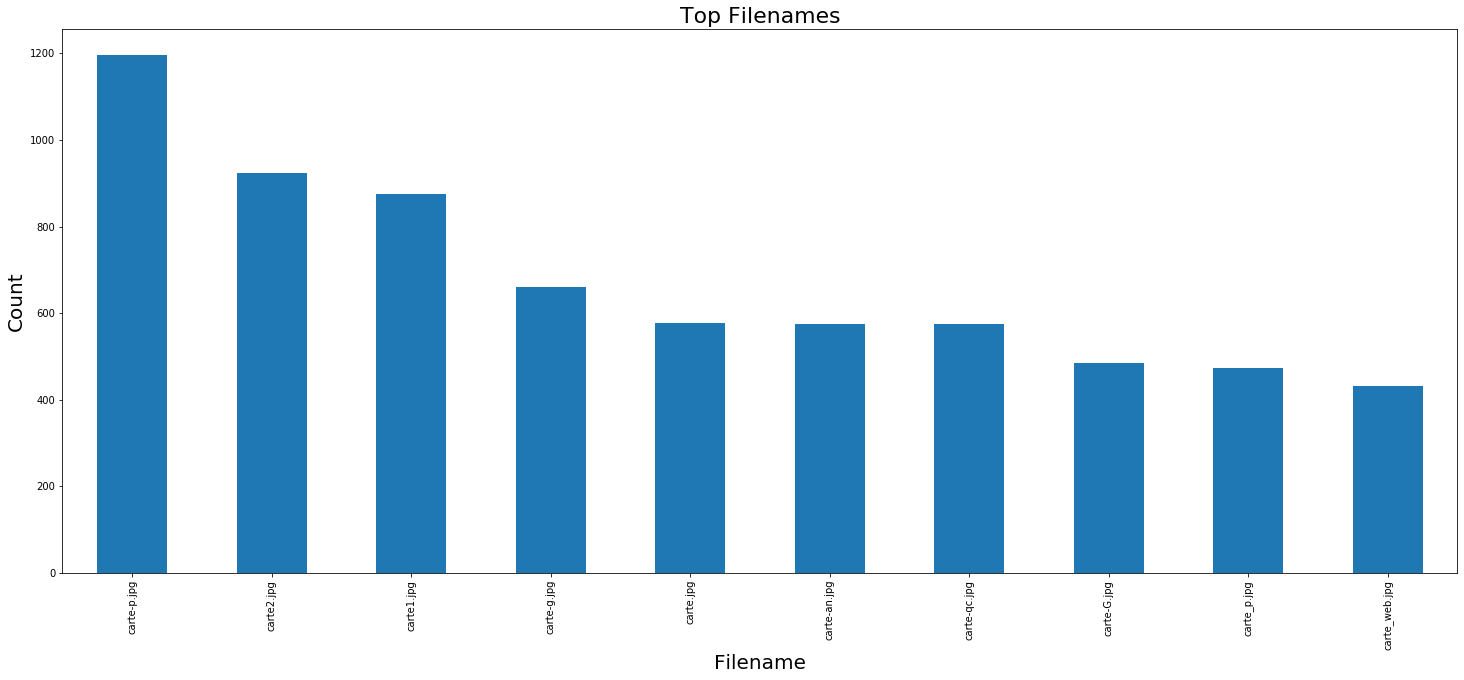

In [13]:
top_filenames_chart = top_filenames.plot.bar(figsize=(25,10))
top_filenames_chart.set_title("Top Filenames", fontsize=22)
top_filenames_chart.set_xlabel("Filename", fontsize=20)
top_filenames_chart.set_ylabel("Count", fontsize=20)

#### How about a MIME type distribution?



Text(0, 0.5, 'Count')

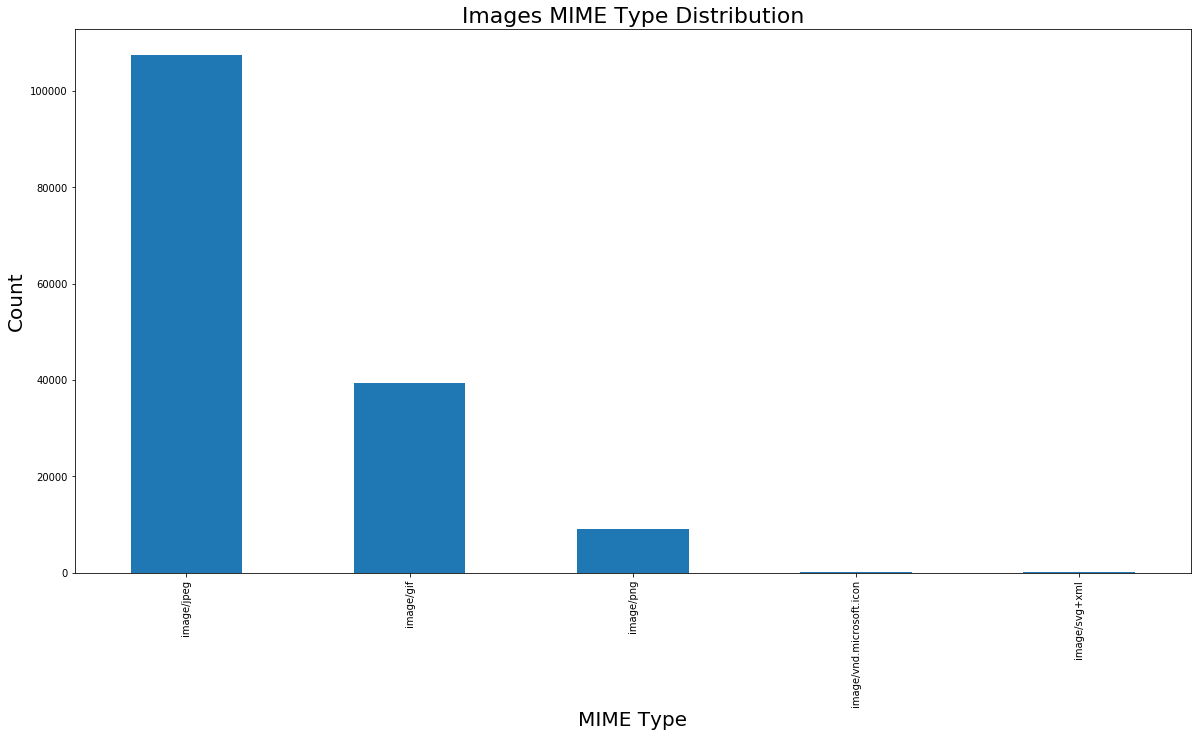

In [14]:
image_mime_types = images['mime_type_tika'].value_counts().head(5)
image_mime_type_chart = image_mime_types.plot.bar(figsize=(20,10))
image_mime_type_chart.set_title("Images MIME Type Distribution", fontsize=22)
image_mime_type_chart.set_xlabel("MIME Type", fontsize=20)
image_mime_type_chart.set_ylabel("Count", fontsize=20)

#### How about the distribution of the top 10 domains?

Text(0, 0.5, 'Count')

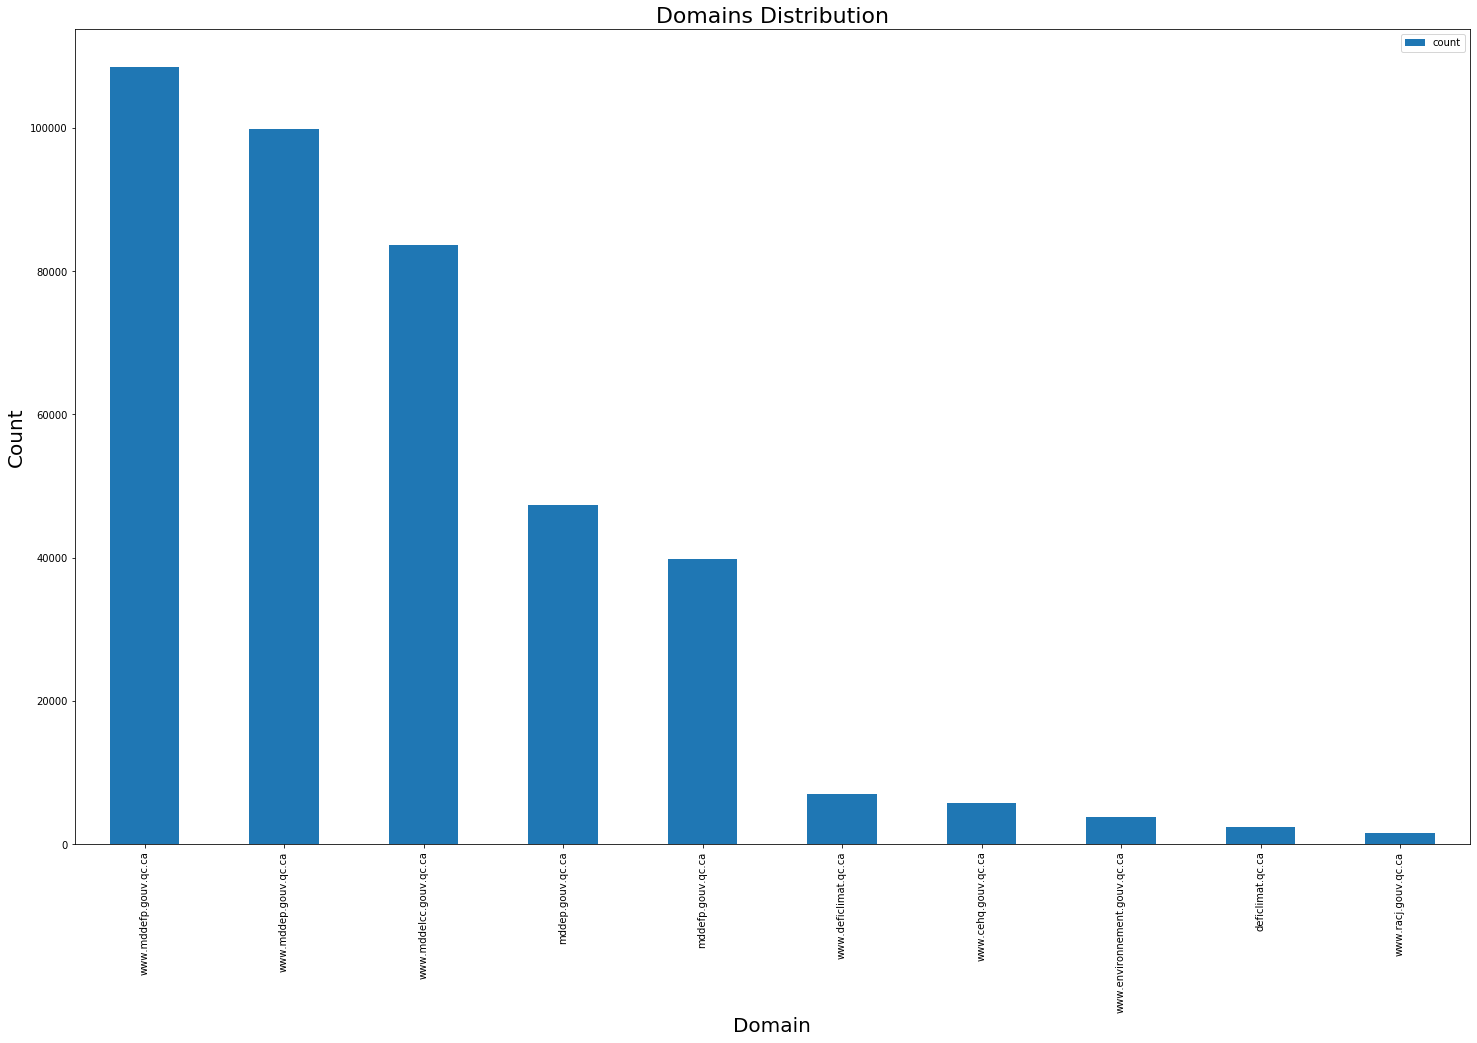

In [15]:
top_domains = domains.sort_values('count', ascending=False).head(10)
top_domains_chart = top_domains.plot.bar(x='url', y='count', figsize=(25,15))
top_domains_chart.set_title("Domains Distribution", fontsize=22)
top_domains_chart.set_xlabel("Domain", fontsize=20)
top_domains_chart.set_ylabel("Count", fontsize=20)

### Top Level Domain Analysis
Next, we'll be creating a new column, `tld`, which is based off an existing column, 'Domain'. This example should give you an idea of how you can expand these datasets to do further research and analysis.

We'll take the `Domain` column, and extract the `tld` from it with [`tldextract`](https://github.com/john-kurkowski/tldextract).

First we'll add the [`tldextract`](https://github.com/john-kurkowski/tldextract)library to the notebook. Then, we'll create the new column.

In [0]:
%%capture

!pip install tldextract

In [17]:
import tldextract

domains['tld'] = domains.apply(lambda row: tldextract.extract(row.url).suffix, axis=1)
domains

,url,count,tld
0,www.mddefp.gouv.qc.ca,108409,qc.ca
1,www.mddep.gouv.qc.ca,99854,qc.ca
2,www.mddelcc.gouv.qc.ca,83594,qc.ca
3,mddep.gouv.qc.ca,47392,qc.ca
4,mddefp.gouv.qc.ca,39783,qc.ca
...,...,...,...
76,www.mnba.qc.ca,1,qc.ca
77,www.cbd.int,1,int
78,s7.addthis.com,1,com
79,www.longtailvideo.com,1,com


#### Next, let's count the distict TLDs.


In [18]:
tld_count = domains['tld'].value_counts()
tld_count

qc.ca    44
com      22
ca       5 
net      4 
gc.ca    3 
org      2 
int      1 
Name: tld, dtype: int64

#### Next, we'll plot the TLD count.


Text(0.5, 1.0, 'Top Level Domain Distribution')

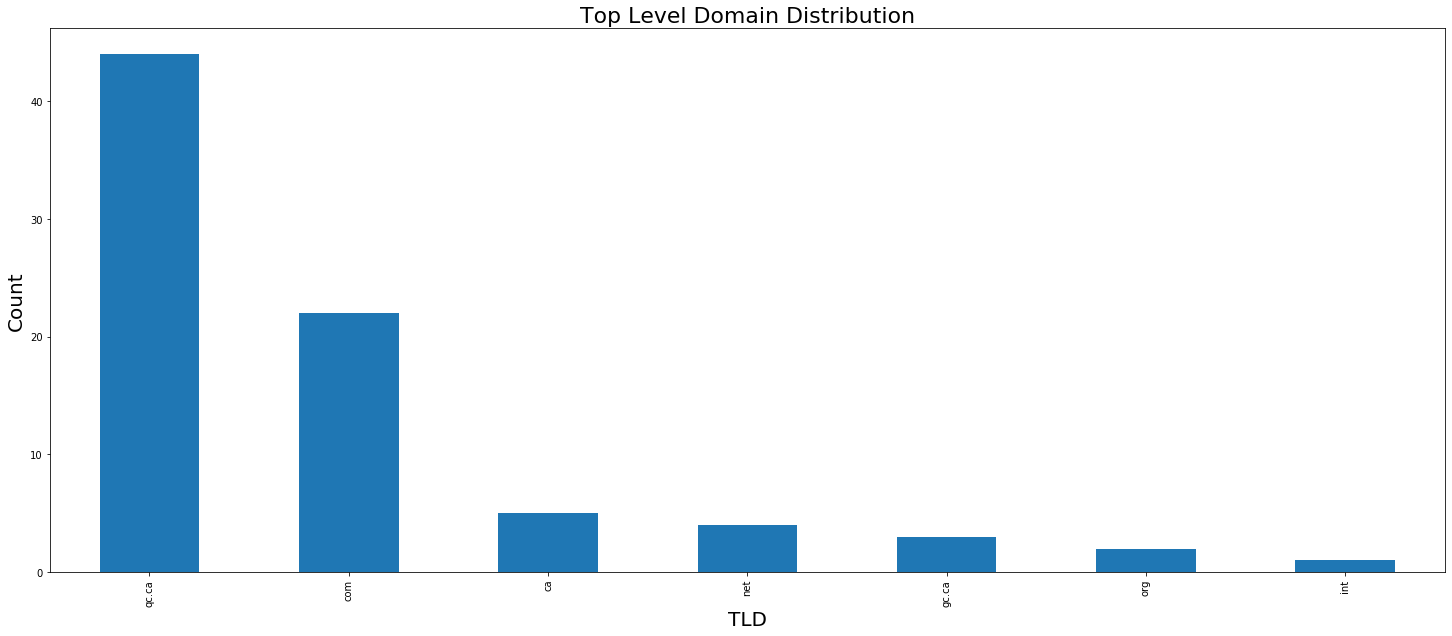

In [19]:
tld_chart = tld_count.plot.bar(legend=None, figsize=(25,10))
tld_chart.set_xlabel("TLD", fontsize=20)
tld_chart.set_ylabel("Count", fontsize=20)
tld_chart.set_title("Top Level Domain Distribution", fontsize=22)

Let's start the text analysis section by installing and importing [`textblob`](https://textblob.readthedocs.io/en/dev/), a really robust text processing Python library, and download some helpful items from [`nltk`](https://www.nltk.org/).

## Examining the Web Graph

Let's start by looking at the web graph columns again.

In [20]:
webgraph

,crawl_date,src,dest,anchor
0,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://www.mddefp.gouv.qc.ca/changements/carbone/reg-mod-reg-spede.pdf,modification r�glementaire
1,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://recherched.gouv.qc.ca/internet/search.do?query=&searchIn=menv&charSet=ISO-8859-1&includesDir=http://www.mddefp.gouv.qc.ca/recherche/&includesExt=asp&displayLang=fr&searchLang=fr&source=IQA&hitsPerPage=10&leftMenu=false&template=default&pageWidth=760px&horizontalAlign=center&headerHeight=140px&bottomHeight=60px&leftMenuWidth=0px &dev=true,Recherche
2,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://www.gouv.qc.ca/,
3,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
4,20121218,http://www.vehiculeselectriques.gouv.qc.ca/english/nous-joindre.asp,http://www.gouv.qc.ca/portail/quebec/pgs/commun/?lang=fr,Québec Portal
...,...,...,...,...
1439507,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090380001&methode=c,http://www.gouv.qc.ca/,
1439508,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090380001&methode=c,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
1439509,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090500006,http://recherched.gouv.qc.ca/internet/search.do?query=&searchIn=menv&charSet=ISO-8859-1&includesDir=http://www.mddefp.gouv.qc.ca/recherche/&includesExt=asp&displayLang=fr&searchLang=fr&source=IQA&hitsPerPage=10&leftMenu=false&template=default&pageWidth=760px&horizontalAlign=center&headerHeight=140px&bottomHeight=60px&leftMenuWidth=0px &dev=true,Recherche
1439510,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090500006,http://www.gouv.qc.ca/,


### What are the most frequent crawl dates?


Text(0.5, 1.0, 'Crawl Date Frequency')

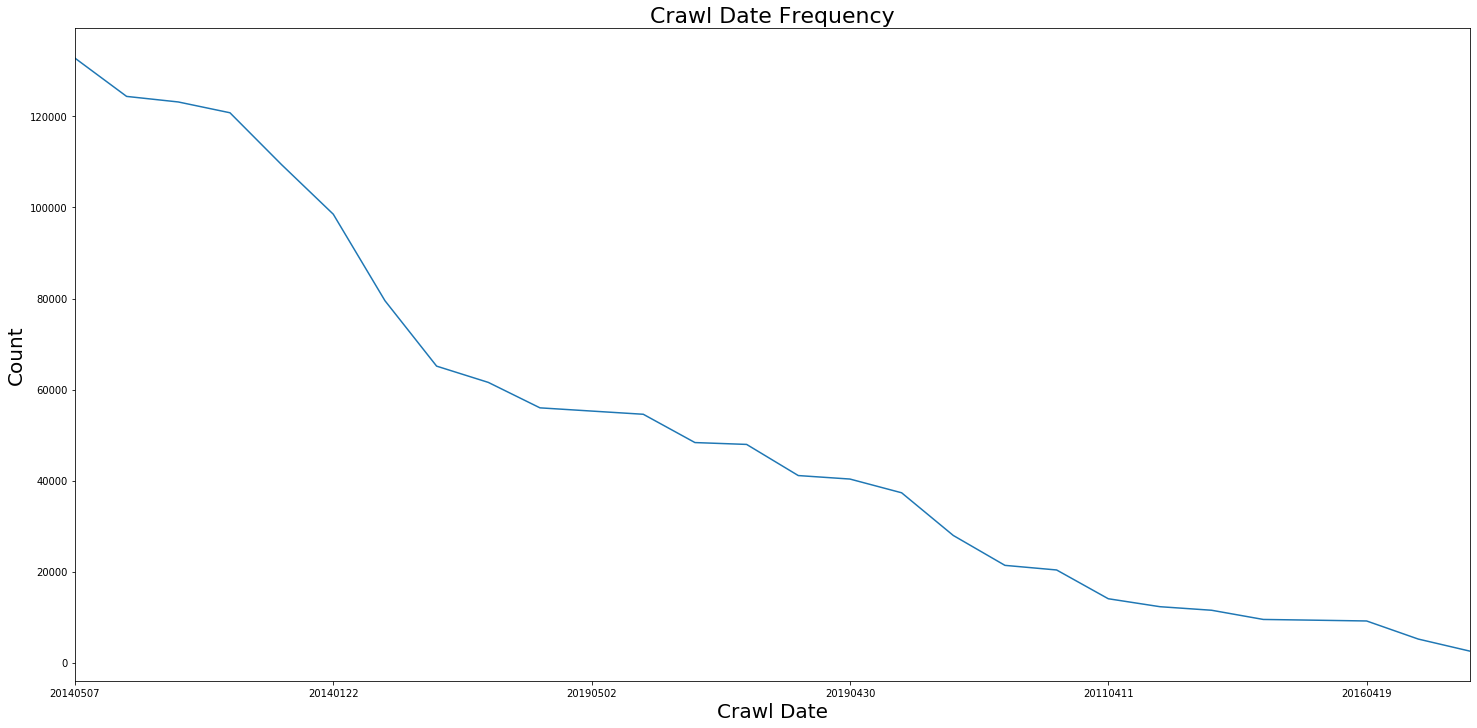

In [21]:
crawl_dates = webgraph['crawl_date'].value_counts()
crawl_dates
crawl_dates_chart = crawl_dates.plot.line(figsize=(25,12))
crawl_dates_chart.set_xlabel("Crawl Date", fontsize=20)
crawl_dates_chart.set_ylabel("Count", fontsize=20)
crawl_dates_chart.set_title("Crawl Date Frequency", fontsize=22)
